In [1]:
import os
from importlib.resources import files
import time

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
# from scipy.spatial.distance import cosine
# from sklearn.metrics.pairwise import cosine_similarity
from learn_embedding.utils.soft_dtw_cuda import SoftDTW
from dtaidistance import dtw_ndim

from learn_diffeomorphism import Dynamics
from learn_embedding.utils import *

In [2]:
dim = 2
num_traj = 7  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory
split = int(np.round(num_traj*0.6))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
data_x = []
data_y = []

data_x_red = []
data_y_red = []

for i in range(1, num_traj+1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    data_red = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + "_red.csv")
    
    # remove last point
    data = data[:-1,:]
    data_red = data_red[:-1,:]
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    
    # center
    data[idx,:2] -= data[-1,:2]
    data_red[:,:2] -= data_red[-1,:2]
    
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    data_red[-1,2:4] = np.zeros(2)
    
    # add to datset
    data_x.append(data[idx,:2])
    data_y.append(data[idx,2:4])
    data_x_red.append(data_red[:,:2])
    data_y_red.append(data_red[:,2:4])

In [4]:
reps = 3
num_epochs = 2000
dt = 0.01
T = 20.0

cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
sdtw = SoftDTW(use_cuda=use_cuda, gamma=0.01)

time_log = torch.zeros(reps).to(device)
loss_log = torch.zeros(reps).to(device)

rmse_log = torch.zeros(reps).to(device)
cos_log = torch.zeros(reps).to(device)
sdtw_log = torch.zeros(reps).to(device)
dtw_log = torch.zeros(reps).to(device)
fdtw_log = torch.zeros(reps).to(device)

for k in range(reps):
    idx = np.random.permutation(num_traj)
    
    train_x = np.empty((0, 2))
    train_y = np.empty((0, 2))
    
    for i in idx[:split]:
        train_x = np.append(train_x, data_x[i], axis=0)
        train_y = np.append(train_y, data_y[i], axis=0)
        
    train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
    train_y = torch.from_numpy(train_y).float().to(device)

    model = Dynamics(dim=dim, num_features=200, num_diff=10, attractor=torch.tensor([0.0,0.0]).to(device), length=1.0).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, 
                                                           threshold=1e-3, threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-8, verbose=True)
    loss_fun = torch.nn.MSELoss()
    
    t0 = time.time()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(train_x)
        loss = loss_fun(pred,train_y)
        loss.backward()
        optimizer.step()
#         scheduler.step(loss)
    train_time = time.time()-t0
    
    loss_log[k] = loss.item()
    time_log[k] = train_time
    
    for i in idx[split:]:
        test_x = torch.from_numpy(data_x[i]).float().to(device).requires_grad_(True)
        test_y = torch.from_numpy(data_y[i]).float().to(device)
        
        x0 = test_x[0,:].unsqueeze(0)
        streamline = Integrator.first_order(dynamics=model,x0=x0,T=T, dt=dt)[:,0,:]
        
        output = model(test_x).detach()
        
        rmse_log[k] += (output-test_y).square().sum().mean().sqrt()/(num_traj-split)
        cos_log[k] += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-split)
        
        series_1 = streamline[:,:2].detach()
        series_2 = test_x.detach()
        sdtw_log[k] += (
            sdtw(series_1.unsqueeze(0), series_2.unsqueeze(0)) 
            -0.5*(sdtw(series_1.unsqueeze(0), series_1.unsqueeze(0)) + sdtw(series_2.unsqueeze(0), series_2.unsqueeze(0)))
        ).detach().squeeze()/(num_traj-split)
        
        series_1 = series_1.cpu().numpy()
        series_2 = series_2.cpu().numpy()
        dtw_log[k] += torch.tensor(dtw_ndim.distance(series_1, series_2)/(num_traj-split)).to(device)
        fdtw_log[k] += torch.tensor(fastdtw(series_1, series_2, dist=euclidean)[0]/(num_traj-split)).to(device)
    
    print("Iter: ", k, "Time: ", train_time, "Loss: ", loss.item(), "RMSE: ", rmse_log[k].item(), "Cosine: ", cos_log[k].item(), "SDTW: ", sdtw_log[k].item(),
         "DTW: ", dtw_log[k].item(), "FDTW: ", fdtw_log[k].item())    

SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


/home/bernardo/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


/home/bernardo/.local/lib/python3.10/site-packages/learn_embedding/utils/soft_dtw_cuda.py:124: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  gamma = torch.cuda.FloatTensor([gamma])
/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)


/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
Iter:  0 Time:  47.50974988937378 Loss:  0.00010669129551388323 RMSE:  0.4503493905067444 Cosine:  0.02100694738328457 SDTW:  10.057616233825684 DTW:  0.3358538746833801 FDTW:  11.372029304504395
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)
SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size

In [5]:
data

array([[ 2.19421880e-01,  8.85308401e-01,  0.00000000e+00,
         0.00000000e+00,  4.83102149e-01, -2.89290990e+00],
       [ 9.00004831e-02, -1.00028929e-02,  4.83102149e-04,
        -2.89290990e-03,  4.79014951e-01, -2.86828202e+00],
       [ 9.00014452e-02, -1.00086541e-02,  9.62117101e-04,
        -5.76119191e-03,  4.74963706e-01, -2.84386627e+00],
       ...,
       [-1.29416633e-01, -8.95309524e-01, -2.62443774e-03,
         5.61663783e-04,  6.29658975e-04, -2.50965353e-04],
       [-1.29419257e-01, -8.95308962e-01, -2.62380808e-03,
         5.61412818e-04,  6.29511980e-04, -2.50888889e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.29365018e-04, -2.50812444e-04]])

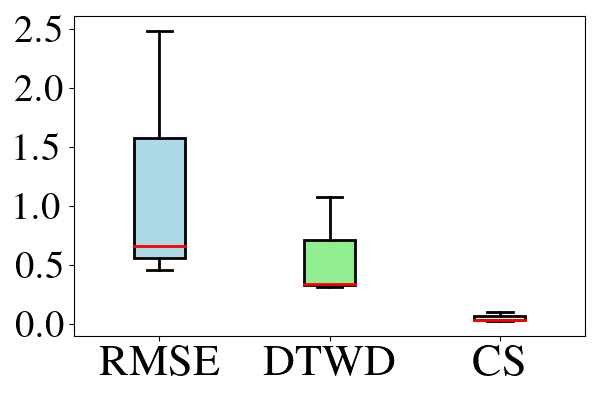

In [9]:
data = [rmse_log.cpu(), dtw_log.cpu(), cos_log.cpu()]
green_diamond = dict(markerfacecolor='g', marker='D')

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Customize the box plot
boxprops = dict(linewidth=2, color='black', facecolor='lightgray')
medianprops = dict(linewidth=2, color='red')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
flierprops = green_diamond

boxplot = ax.boxplot(data, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops,
           capprops=capprops, flierprops=flierprops, patch_artist=True)

# Define a list of colors
colors = ['lightblue', 'lightgreen', 'lightyellow']

# Add color to the box plot elements
for patch, color in zip(boxplot['boxes'], colors):
    # Change the fill color of the boxes
    patch.set_facecolor(color)

# Customize the x-axis ticks and labels
plt.xticks([1, 2, 3], ['RMSE', 'DTWD', 'CS'], fontsize=32)
plt.yticks(fontsize=28)
# plt.xlabel('Metrics')

# Add a title and y-axis label if needed
# plt.title('Comparison of Metrics')
# plt.ylabel('Metric Values')

# Adjust the plot layout if needed
plt.tight_layout()

fig.savefig('../outputs/evaluation_learning_baseline.png', format='png', dpi=300, bbox_inches="tight")

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')
grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)

potential, _ = model.potential(grid_x)
potential = potential.reshape(resolution, -1).cpu().detach().numpy()

field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = np.empty((0, 2))
test_x = np.empty((0, 2))
for i in idx[split:]:
    x0 = np.append(x0, data_x[i][0,:][np.newaxis, :], axis=0)
    test_x = np.append(test_x, data_x[i], axis=0)
x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)

streamlines = Integrator.first_order(dynamics=model,x0=x0,T=T, dt=dt).cpu().detach().numpy()

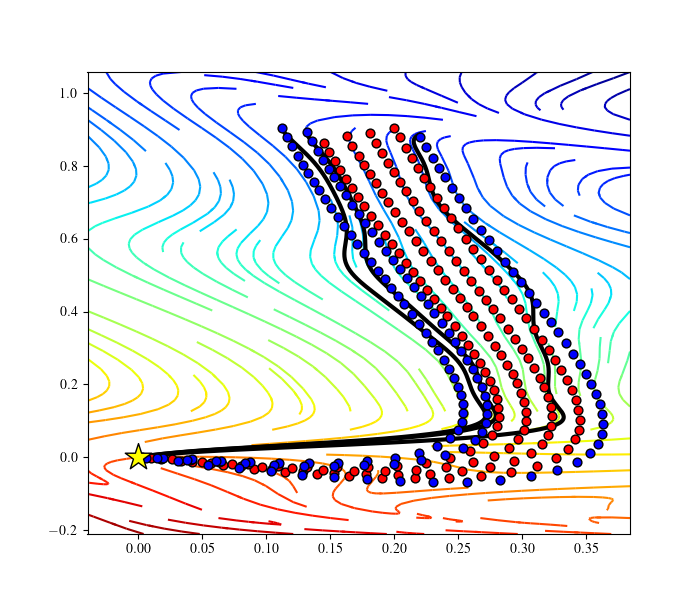

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(test_x[::steps, 0], test_x[::steps, 1], s=40, edgecolors='k', c='blue', zorder=10)

ax.scatter(0.0, 0.0, s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)